In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


실습 데이터셋 : https://drive.google.com/file/d/1T7xY3HgvArsrpK2Zvq4uWEZDr2zbs4ly/view?usp=sharing

Google Drive에 마운트 한 뒤 데이터셋을 업로드합니다.


업로드가 완료되면 해당 파일이 속해있는 폴더 경로를 folder_path 변수에 입력해주세요.

# 필요 함수 호출 및 데이터 로드

In [2]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.3 MB/s eta 0:00:00


In [3]:
folder_path = '/content/drive/MyDrive'

In [4]:
import os
from itertools import repeat

# torch imports
import torch
from torch.utils.data.dataset import Dataset
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch import optim
from torch.optim import lr_scheduler

from sklearn.preprocessing import MinMaxScaler

# Tensorboard import
from tensorboardX import SummaryWriter

# Numpy, Pandas, Matplotlib imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter

# 커스텀 데이터셋 구축

In [5]:
class SP500(Dataset):
    def __init__(self, folder_dataset, T=10, symbols=['AAPL'], use_columns=['date', 'close'], start_date='2012-01-01',
                 end_date='2015-12-31', step=1):

        self.scaler = MinMaxScaler()
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.use_columns = use_columns
        self.T = T

        # Create output dataframe
        self.dates = pd.date_range(self.start_date, self.end_date)
        self.df_data = pd.DataFrame(index=self.dates)

        # Read csv files corresponding to symbols
        for symbol in symbols:
            fn = os.path.join(folder_dataset, symbol + "_data.csv")
            print(fn)
            df_current = pd.read_csv(fn, index_col='date', usecols=self.use_columns, na_values='nan', parse_dates=True)
            df_current = df_current.rename(columns={'close': symbol})
            self.df_data = self.df_data.join(df_current)

        # Replace NaN values with forward then backward filling
        self.df_data.fillna(method='ffill', inplace=True, axis=0)
        self.df_data.fillna(method='bfill', inplace=True, axis=0)
        self.numpy_data = self.df_data.to_numpy()
        self.train_data = self.scaler.fit_transform(self.numpy_data)

        self.chunks = torch.FloatTensor(self.train_data).unfold(0, self.T, step).permute(0, 2, 1)

    def __getitem__(self, index):

        x = self.chunks[index, :-1, :]
        y = self.chunks[index, -1, :]
        return x, y

    def __len__(self):
        return self.chunks.size(0)

# Dilated Convolution

기존의 convolution보다 더 넓은 receptive field를 가지기 위해
커널 크기를 확장한다던지, 더 많은 convolution 층을 쌓을 수도 있지만 두 방법 모두 연산량을 크게 증가 시킨다는 단점이 있다.

**Vanilla Convolution**

<img src = 'https://drive.google.com/uc?id=1eYvV_2KGhV1AgsO0tDB8hfrZPAFuGjd7' height=300 width=300>



**Dilated Convolution**

<img src = 'https://drive.google.com/uc?id=1i1uluQw8KEru9Y9UWvZ71MxT7LrY9mhy' height=300 width=300>

Dilated Convolution은 기존 convolution 필터가 수용하는 픽셀 사이에 간격을 둔 형태이다.
입력 픽셀 수는 동일하지만, 더 넓은 범위에 대한 입력을 수용할 수 있게 된다.

dilation rate가 2인 3x3 커널은 9개의 파라미터를 사용하면서, 5x5 커널과 동일한 view를 가지게 된다.(5x5 커널은 25개의 파라미터를 사용)

# 1d CNN 모델 정의

In [6]:
class DilatedNet(nn.Module):
    def __init__(self, num_securities=5, hidden_size=64, dilation=2, T=10):
        self.T = T
        super(DilatedNet, self).__init__()
        self.dilation = dilation
        self.hidden_size = hidden_size
        # First Layer
        # Input
        self.dilated_conv1 = nn.Conv1d(num_securities, hidden_size, kernel_size=2, dilation=self.dilation)
        self.relu1 = nn.ReLU()
        # Layer 2
        self.dilated_conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1, dilation=self.dilation)
        self.relu2 = nn.ReLU()
        # Layer 3
        self.dilated_conv3 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1, dilation=self.dilation)
        self.relu3 = nn.ReLU()
        # Layer 4
        self.dilated_conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1, dilation=self.dilation)
        self.relu4 = nn.ReLU()
        # Output layer
        self.conv_final = nn.Conv1d(hidden_size, num_securities, kernel_size=1)

    def forward(self, x):

        # First layer
        out = self.dilated_conv1(x)
        out = self.relu1(out)
        # Layer 2:
        out = self.dilated_conv2(out)
        out = self.relu2(out)
        # Layer 3:
        out = self.dilated_conv3(out)
        out = self.relu3(out)
        # Layer 4:
        out = self.dilated_conv4(out)
        out = self.relu4(out)
        # Final layer
        out = self.conv_final(out)
        out = out[:, :, -1]

        return out

# 2d CNN 모델 정의

In [7]:
class DilatedNet2D(nn.Module):
    def __init__(self, hidden_size=64, dilation=1, T=10):

        self.T = T
        super(DilatedNet2D, self).__init__()
        self.dilation = dilation
        self.hidden_size = hidden_size
        self.dilated_conv1 = nn.Conv2d(1, hidden_size, kernel_size=(1, 2), dilation=(1, self.dilation))
        self.relu1 = nn.ReLU()
        self.dilated_conv2 = nn.Conv2d(hidden_size, hidden_size, kernel_size=(1, 2), dilation=(1, self.dilation))
        self.relu2 = nn.ReLU()
        self.dilated_conv3 = nn.Conv2d(hidden_size, hidden_size, kernel_size=(1, 2), dilation=(1, self.dilation))
        self.relu3 = nn.ReLU()
        self.dilated_conv4 = nn.Conv2d(hidden_size, hidden_size, kernel_size=(1, 2), dilation=(1, self.dilation))
        self.relu4 = nn.ReLU()
        self.conv_final = nn.Conv2d(hidden_size, 1, kernel_size=(1, 2))

    def forward(self, x):

        out = self.dilated_conv1(x)
        out = self.relu1(out)
        out = self.dilated_conv2(out)
        out = self.relu2(out)
        out = self.dilated_conv3(out)
        out = self.relu3(out)
        out = self.dilated_conv4(out)
        out = self.relu4(out)
        out = self.conv_final(out)
        out = out[:, :, :, -1]
        return out

# 모델 파라미터 설정

In [8]:
# Parameters
learning_rate = 0.001
batch_size = 16
display_step = 20
max_epochs = 100
symbols = ['AAPL']
n_stocks = len(symbols)
n_hidden1 = 128
n_hidden2 = 128
n_steps_encoder = 20  # time steps, length of time window
n_output = n_stocks
T = 20
start_date = '2013-01-01'
end_date = '2013-12-31'
n_step_data = 10
weight_decay = 0.01

# 모델 학습

/content/drive/MyDrive/AAPL_data.csv


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might ge

Epoch =  0
Loss =  tensor(4.7661)


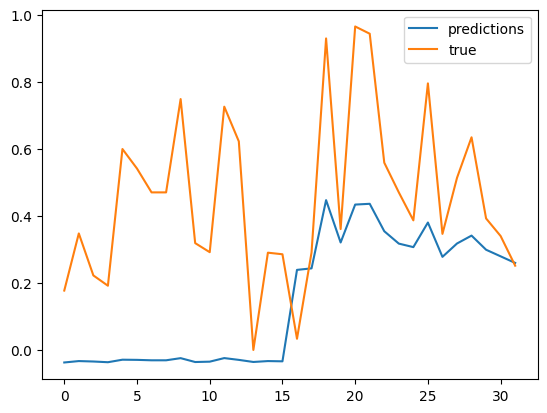

Epoch =  1
Loss =  tensor(13.7463)
Epoch =  2
Loss =  tensor(1.3375)
Epoch =  3
Loss =  tensor(0.7472)
Epoch =  4
Loss =  tensor(0.6495)
Epoch =  5
Loss =  tensor(0.6421)
Epoch =  6
Loss =  tensor(0.5999)
Epoch =  7
Loss =  tensor(0.5557)
Epoch =  8
Loss =  tensor(0.3703)
Epoch =  9
Loss =  tensor(0.4651)
Epoch =  10
Loss =  tensor(0.4268)
Epoch =  11
Loss =  tensor(0.3903)
Epoch =  12
Loss =  tensor(0.3570)
Epoch =  13
Loss =  tensor(0.2821)
Epoch =  14
Loss =  tensor(0.3491)
Epoch =  15
Loss =  tensor(0.3282)
Epoch =  16
Loss =  tensor(0.2815)
Epoch =  17
Loss =  tensor(0.2871)
Epoch =  18
Loss =  tensor(0.2865)
Epoch =  19
Loss =  tensor(0.2866)
Epoch =  20
Loss =  tensor(0.2469)


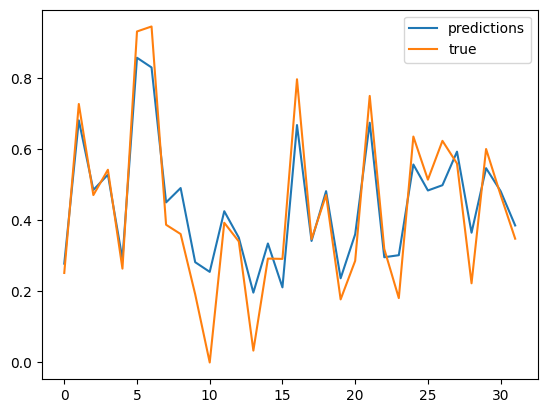

Epoch =  21
Loss =  tensor(0.2719)
Epoch =  22
Loss =  tensor(0.2489)
Epoch =  23
Loss =  tensor(0.2481)
Epoch =  24
Loss =  tensor(0.2637)
Epoch =  25
Loss =  tensor(0.2387)
Epoch =  26
Loss =  tensor(0.2245)
Epoch =  27
Loss =  tensor(0.2428)
Epoch =  28
Loss =  tensor(0.2341)
Epoch =  29
Loss =  tensor(0.2120)
Epoch =  30
Loss =  tensor(0.2394)
Epoch =  31
Loss =  tensor(0.2413)
Epoch =  32
Loss =  tensor(0.2146)
Epoch =  33
Loss =  tensor(0.2137)
Epoch =  34
Loss =  tensor(0.2392)
Epoch =  35
Loss =  tensor(0.2412)
Epoch =  36
Loss =  tensor(0.1635)
Epoch =  37
Loss =  tensor(0.2134)
Epoch =  38
Loss =  tensor(0.2184)
Epoch =  39
Loss =  tensor(0.2355)
Epoch =  40
Loss =  tensor(0.2055)


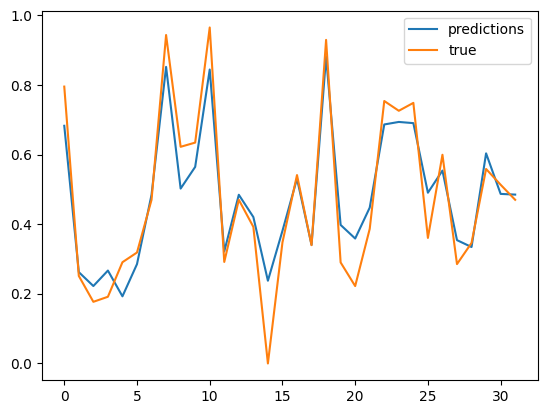

Epoch =  41
Loss =  tensor(0.1674)
Epoch =  42
Loss =  tensor(0.1999)
Epoch =  43
Loss =  tensor(0.2343)
Epoch =  44
Loss =  tensor(0.2351)
Epoch =  45
Loss =  tensor(0.2316)
Epoch =  46
Loss =  tensor(0.2204)
Epoch =  47
Loss =  tensor(0.1667)
Epoch =  48
Loss =  tensor(0.2189)
Epoch =  49
Loss =  tensor(0.1740)
Epoch =  50
Loss =  tensor(0.2335)
Epoch =  51
Loss =  tensor(0.2280)
Epoch =  52
Loss =  tensor(0.2081)
Epoch =  53
Loss =  tensor(0.2327)
Epoch =  54
Loss =  tensor(0.1474)
Epoch =  55
Loss =  tensor(0.2333)
Epoch =  56
Loss =  tensor(0.1932)
Epoch =  57
Loss =  tensor(0.2021)
Epoch =  58
Loss =  tensor(0.2184)
Epoch =  59
Loss =  tensor(0.2213)
Epoch =  60
Loss =  tensor(0.2225)


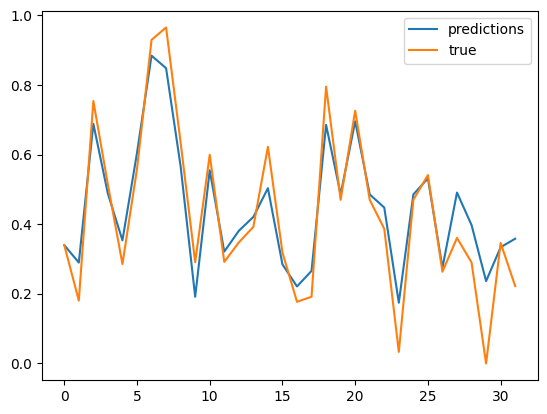

Epoch =  61
Loss =  tensor(0.2284)
Epoch =  62
Loss =  tensor(0.2107)
Epoch =  63
Loss =  tensor(0.2053)
Epoch =  64
Loss =  tensor(0.2195)
Epoch =  65
Loss =  tensor(0.2024)
Epoch =  66
Loss =  tensor(0.2147)
Epoch =  67
Loss =  tensor(0.2147)
Epoch =  68
Loss =  tensor(0.2164)
Epoch =  69
Loss =  tensor(0.1946)
Epoch =  70
Loss =  tensor(0.2060)
Epoch =  71
Loss =  tensor(0.2314)
Epoch =  72
Loss =  tensor(0.1632)
Epoch =  73
Loss =  tensor(0.1761)
Epoch =  74
Loss =  tensor(0.2136)
Epoch =  75
Loss =  tensor(0.1626)
Epoch =  76
Loss =  tensor(0.2068)
Epoch =  77
Loss =  tensor(0.2288)
Epoch =  78
Loss =  tensor(0.2166)
Epoch =  79
Loss =  tensor(0.1749)
Epoch =  80
Loss =  tensor(0.2146)


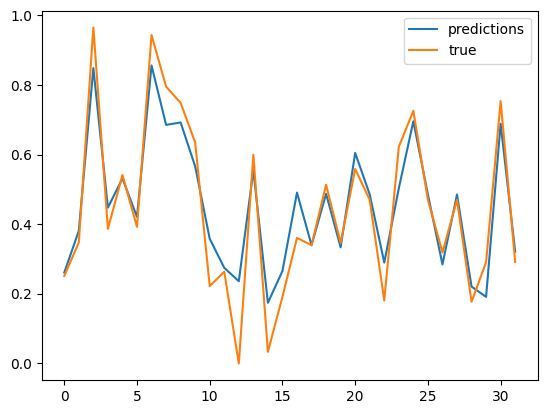

Epoch =  81
Loss =  tensor(0.2325)
Epoch =  82
Loss =  tensor(0.2121)
Epoch =  83
Loss =  tensor(0.2152)
Epoch =  84
Loss =  tensor(0.2306)
Epoch =  85
Loss =  tensor(0.2306)
Epoch =  86
Loss =  tensor(0.2079)
Epoch =  87
Loss =  tensor(0.2225)
Epoch =  88
Loss =  tensor(0.2214)
Epoch =  89
Loss =  tensor(0.2130)
Epoch =  90
Loss =  tensor(0.2144)
Epoch =  91
Loss =  tensor(0.2229)
Epoch =  92
Loss =  tensor(0.2242)
Epoch =  93
Loss =  tensor(0.2119)
Epoch =  94
Loss =  tensor(0.2299)
Epoch =  95
Loss =  tensor(0.2143)
Epoch =  96
Loss =  tensor(0.2179)
Epoch =  97
Loss =  tensor(0.2281)
Epoch =  98
Loss =  tensor(0.2013)
Epoch =  99
Loss =  tensor(0.2316)


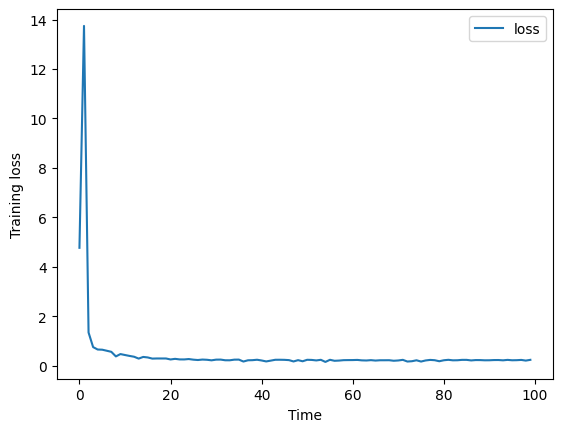

In [11]:
# Use cuda if available
use_cuda = torch.cuda.is_available()
# Keep track of loss in tensorboard
writer = SummaryWriter()

fn_base = "nstocks_" + str(n_stocks) + "_epochs_" + str(max_epochs) + "_T_" + str(T) + "_weight_decay_" + \
          str(weight_decay) + "_train_" + start_date + \
          "_" + end_date

# Training data
dset = SP500(folder_path,
              symbols=symbols,
              start_date=start_date,
              end_date=end_date,
              T=T,
              step=n_step_data)
train_loader = DataLoader(dset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=use_cuda  # CUDA only
                          )

# Network Definition + Optimizer + Scheduler
model = DilatedNet2D(T=T,  hidden_size=64, dilation=2)
if use_cuda:
    model = model.cuda()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler_model = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# loss function
criterion = nn.MSELoss(size_average=False).cuda()
# Store successive losses
losses = []
for i in range(max_epochs):
    loss_ = 0.
    predicted = []
    gt = []
    # Go through training data set
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.permute(0, 2, 1)).unsqueeze_(1).contiguous()
        target = Variable(target.unsqueeze_(1))
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        if target.data.size()[0] == batch_size:
            # Set gradient of optimizer to 0
            optimizer.zero_grad()
            # Compute predictions
            output = model(data)
            # Compute loss
            loss = criterion(output, target)
            loss_ += loss.data
            # Backpropagation
            loss.backward()
            # Gradient descent step
            optimizer.step()
            # Store current results for visual check
            for k in range(batch_size):
                predicted.append(output.data[k, 0, :].cpu().numpy())
                gt.append(target.data[k, 0, :].cpu().numpy())

    print("Epoch = ", i)
    print("Loss = ", loss_)
    losses.append(loss_)
    # Store for display in Tensorboard
    writer.add_scalar("loss_epoch", loss_, i)
    # Apply step of scheduler for learning rate change
    scheduler_model.step()
    # Plot current predictions
    if i % display_step == 0:
        predicted = np.array(predicted)
        gt = np.array(gt)
        x = np.array(range(predicted.shape[0]))
        h = plt.figure()
        plt.plot(x, predicted[:, 0], label="predictions")
        plt.plot(x, gt[:, 0], label="true")
        plt.legend()
        plt.show()

# Save trained models
torch.save(model, 'conv2d_' + fn_base + '.pkl')
# Plot training loss
h = plt.figure()
x = range(len(losses))
plt.plot(np.array(x), np.array(losses), label="loss")
plt.xlabel("Time")
plt.ylabel("Training loss")
plt.savefig("loss_" + fn_base + '.png')
plt.legend()
plt.show()

# 모델 성능 평가

In [12]:
# TEST
predictions = np.zeros((len(train_loader.dataset.chunks), n_stocks))
ground_tr = np.zeros((len(train_loader.dataset.chunks), n_stocks))
batch_size_pred = batch_size

# Create test data set
start_date = '2013-01-01'
end_date = '2017-10-31'
dtest = SP500(folder_path,
              symbols=symbols,
              start_date=start_date,
              end_date=end_date,
              T=T)
test_loader = DataLoader(dtest,
                          batch_size=batch_size_pred,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True  # CUDA only
                          )

# Create list of n_stocks lists for storing predictions and GT
predictions = [[] for i in repeat(None, len(symbols))]
gts = [[] for i in repeat(None, len(symbols))]
k = 0
# Predictions
for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data.permute(0, 2, 1)).unsqueeze_(1).contiguous()
    target = Variable(target.unsqueeze_(1))
    if use_cuda:
        data = data.cuda()
        target = target.cuda()
    k = 0
    if target.data.size()[0] == batch_size_pred:
        output = model(data)
        for i in range(batch_size_pred):
            s = 0
            for stock in symbols:
                predictions[s].append(output.data[i, 0, s])
                gts[s].append(target.data[i, 0, s])
                s += 1
            k += 1

/content/drive/MyDrive/AAPL_data.csv


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


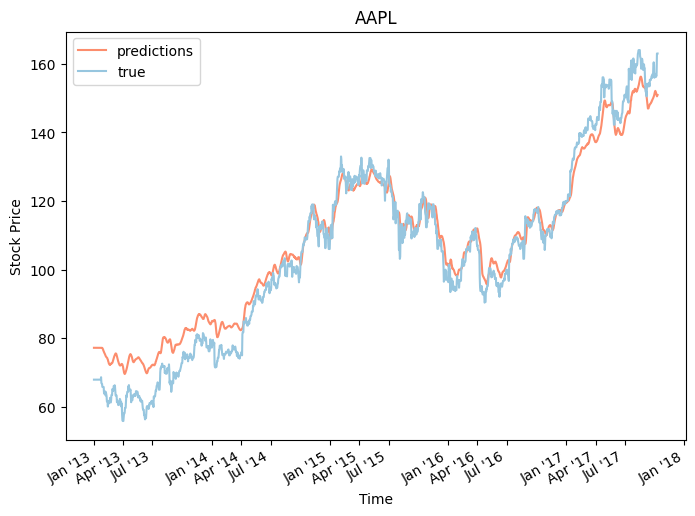

In [13]:
# Plot results
# Convert lists to np array for plot, and rescaling to original data
if len(symbols) == 1:
    pred = dtest.scaler.inverse_transform(np.array(predictions[0]).reshape((len(predictions[0]), 1)))
    gt = dtest.scaler.inverse_transform(np.array(gts[0]).reshape(len(gts[0]), 1))
if len(symbols) >= 2:
    p = np.array(predictions)
    pred = dtest.scaler.inverse_transform(np.array(predictions).transpose())
    gt = dtest.scaler.inverse_transform(np.array(gts).transpose())
# Plot for all stocks in
x = [np.datetime64(start_date) + np.timedelta64(x, 'D') for x in range(0, pred.shape[0])]
x = np.array(x)
months = MonthLocator(range(1, 10), bymonthday=1, interval=3)
monthsFmt = DateFormatter("%b '%y")
s = 0
for stock in symbols:
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    plt.plot(x, pred[:, s], label="predictions", color=cm.Reds(100))
    plt.plot(x, gt[:, s], label="true", color=cm.Blues(100))
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    plt.title(stock)
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    fig.autofmt_xdate()
    plt.savefig(stock + "_" + fn_base + '.png')
    plt.show()
    s += 1